# Iterative ICA - Characterization_Run_1_to_4 

In [1]:
from pathlib import Path
import sys
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import f_oneway, gaussian_kde, mannwhitneyu, pearsonr, spearmanr
import seaborn as sns
from tqdm.notebook import tqdm
from pymodulon.compare import compare_ica
from pymodulon.core import IcaData
from pymodulon.io import load_json_model, save_to_json
from pymodulon.plotting import *

from pymodulon.util import explained_variance
from pymodulon.imodulondb import imdb_gene_presence
sns.set_style('whitegrid')

## Load the data

In [2]:
biocyc_info = pd.read_csv('biocyc_info.txt', sep="\t")

In [3]:
precise1k = load_json_model('p1k.json.gz')

In [4]:
P1K_M = precise1k.M

In [5]:
P1K_Gene_Presence_Matrix = pd.read_csv("../p1k_data_files/gene_presence_matrix.csv", index_col=0)

In [6]:
P1K_Gene_Presence_Matrix.columns = precise1k.A.index

In [7]:
P1K_minicoli_removed_X = pd.read_csv('./P1K_minicoli_removed/P1K_minicoli_removed_X.csv', index_col=0)

In [8]:
P1K_minicoli_removed_X

,p1k_00001,p1k_00002,p1k_00003,p1k_00004,p1k_00005,p1k_00006,p1k_00007,p1k_00008,p1k_00009,p1k_00010,...,p1k_01046,p1k_01047,p1k_01048,p1k_01049,p1k_01050,p1k_01051,p1k_01052,p1k_01053,p1k_01054,p1k_01055
b0002,-0.053993,0.053993,0.879043,1.089600,0.182453,-0.078873,-0.837092,-0.502703,0.421312,0.412354,...,-0.868029,-2.012060,-1.862453,-1.950586,-1.642161,-1.666869,-0.639387,-1.552748,-1.892598,-1.831359
b0003,-0.061973,0.061973,1.063330,1.477889,0.392573,0.234671,-0.763015,-0.120989,0.546181,0.520841,...,-1.501588,-2.532496,-2.515189,-2.443481,-2.258418,-2.312108,-1.124294,-2.060022,-2.348524,-2.122772
b0004,-0.036972,0.036972,0.003132,0.356702,-0.096756,-0.334913,-1.714913,-1.322707,-0.234147,-0.250669,...,-0.691635,-1.692102,-1.608955,-1.723764,-1.376420,-1.251488,-0.529185,-1.577833,-1.383521,-1.527079
b0005,-0.104967,0.104967,-1.118145,-1.277963,-0.181546,-0.364057,-2.121475,-1.994770,-0.386684,-0.634659,...,-2.925632,-4.626965,-4.067417,-2.964371,-3.075562,-3.101967,-2.210546,-3.821019,-4.563928,-2.946659
b0006,0.042242,-0.042242,-0.123592,-0.107778,-0.173177,-0.089888,-0.208133,-0.003044,-0.034707,-0.027806,...,0.190536,-0.618740,-0.175381,-0.317349,-0.466331,-0.169979,-0.402588,-0.915991,-0.804728,-0.858978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4747,0.619141,-0.619141,-0.619141,-0.619141,0.202715,-0.619141,0.734510,-0.619141,0.790289,0.284033,...,-0.619141,0.766947,-0.619141,-0.619141,-0.619141,-0.619141,-0.619141,-0.619141,-0.619141,1.164489
b4748,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.421363,0.000000,0.000000,0.000000,...,5.441998,5.734377,5.614587,5.648036,5.957326,6.657140,3.672372,4.138619,5.809142,4.465101
b4751,-0.039552,0.039552,-1.290021,-1.298327,-0.481621,-0.609865,-1.680827,-1.239934,-0.134430,-0.363082,...,0.274369,-0.356653,-0.371515,-0.064824,-0.504051,0.323457,-1.267812,-0.534742,0.039449,-0.051373
b4755,-0.235166,0.235166,2.621649,3.256277,-0.302443,-0.096198,2.518406,3.268205,1.379971,0.910647,...,-0.633352,-0.039091,-0.136657,0.734843,1.699093,-2.399592,-2.399592,3.413940,1.914515,1.564518


**Notes:**

1. **Only take components appear in more than 95 runs in to final M for each round "Most Robust"**
2. **Rerun ICA 100 times on X_round_N+1 = X_round_N - X_round_reconstructed_by_M_and_A**
3. **Exp Var for round 1 = 0.6602858204981917 - Optimal Dim 260**
4. **Exp Var for round 2 = 0.4368269977132547 - Optimal Dim 140**
5. **Exp Var for round 3 = 0.17144329165003513 - Optimal Dim 120**
6. **Exp Var for round 4 = 0.16575621684232644 - Optimal Dim 100 (These are exp var for X_round_N not original X)**

In [9]:
round_1_M = pd.read_csv('./First_run_100_400/M.csv', index_col=0)
round_1_M.columns = [f"A_{i+1}" for i in range(round_1_M.shape[1])]
round_1_M.shape

(4257, 138)

In [10]:
round_2_M = pd.read_csv('./Second_run_100_300/M.csv', index_col=0)
round_2_M.columns = [f"B_{i+1}" for i in range(round_2_M.shape[1])]
round_2_M.shape

(4257, 39)

In [11]:
round_3_M = pd.read_csv('./Third_run_60_180/M.csv', index_col=0)
round_3_M.columns = [f"C_{i+1}" for i in range(round_3_M.shape[1])]
round_3_M.shape

(4257, 15)

In [12]:
round_4_M = pd.read_csv('./Fourth_run_40_120/M.csv', index_col=0)
round_4_M.columns = [f"D_{i+1}" for i in range(round_4_M.shape[1])]
round_4_M.shape

(4257, 10)

In [13]:
# Merge them to one M
M_merged = pd.concat([round_1_M, round_2_M, round_3_M, round_4_M], axis=1)

In [14]:
M_merged.to_csv('M_robust_iterative.csv')

## Compare to PRECISE_1K iM

In [15]:
import pandas as pd
import numpy as np

file1 = M_merged
file2 = P1K_M

# Make sure the index is sorted
file1 = file1.sort_index()
file2 = file2.sort_index()

# Check if the geneids are the same in both files
if not file1.index.equals(file2.index):
    raise ValueError("The geneids are not the same in both files.")

# Initialize the output dataframe
Match_robust_iterative_M_to_P1K = pd.DataFrame(columns=['Merged M', 'PRECISE-1K', 'correlation', 'status'])

# Calculate the correlation between columns
for col1 in file1.columns:
    max_corr = -1  # initialize with a negative value to ensure any real correlation is higher
    max_col2 = None
    for col2 in file2.columns:
        corr = np.corrcoef(file1[col1], file2[col2])[0, 1]
        if abs(corr) > max_corr:  # compare using absolute value of correlation
            max_corr = abs(corr)
            max_col2 = col2
            actual_corr = abs(corr)  # keep the actual correlation to store in the dataframe
    
    # Determine the status based on the absolute correlation value
    status = "Match" if max_corr > 0.5 else "New"
    
    # Append to the dataframe with the actual correlation
    Match_robust_iterative_M_to_P1K = Match_robust_iterative_M_to_P1K.append({'Merged M': col1, 'PRECISE-1K': max_col2, 'correlation': actual_corr, 'status': status}, ignore_index=True)

In [16]:
Match_robust_iterative_M_to_P1K

,Merged M,PRECISE-1K,correlation,status
0,A_1,ROS TALE Del-1,0.985563,Match
1,A_2,Pyruvate-1,0.986779,Match
2,A_3,UC-1,0.924637,Match
3,A_4,ldrC,0.953895,Match
4,A_5,Pyrimidine,0.981011,Match
...,...,...,...,...
197,D_6,ythA,0.063583,New
198,D_7,Ile/Val,0.226047,New
199,D_8,gcvB,0.909433,Match
200,D_9,NO Stress,0.089100,New


<AxesSubplot:>

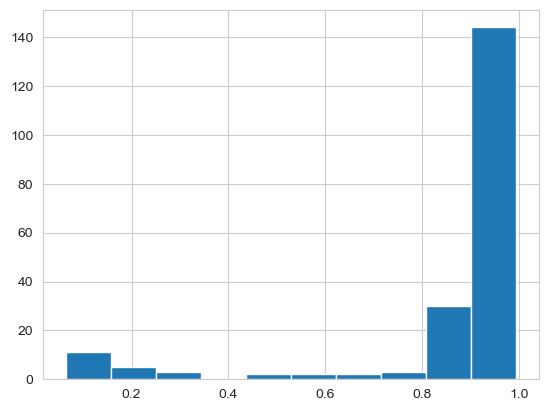

In [17]:
Match_robust_iterative_M_to_P1K['correlation'].hist()

In [18]:
Match_robust_iterative_M_to_P1K.to_csv('Match_Clean_iterative_M_to_P1K.csv')

In [19]:
Match_robust_iterative_M_to_P1K.loc[Match_robust_iterative_M_to_P1K['status'] == 'Match']

,Merged M,PRECISE-1K,correlation,status
0,A_1,ROS TALE Del-1,0.985563,Match
1,A_2,Pyruvate-1,0.986779,Match
2,A_3,UC-1,0.924637,Match
3,A_4,ldrC,0.953895,Match
4,A_5,Pyrimidine,0.981011,Match
...,...,...,...,...
188,C_12,ygdT,0.885640,Match
190,C_14,yqhI,0.859933,Match
192,D_1,entC/ubiC KO-1,0.589499,Match
195,D_4,IS Elements-1,0.894850,Match


### Check if matched iMs are unique

In [20]:
Match_robust_iterative_M_to_P1K.loc[Match_robust_iterative_M_to_P1K['status'] == 'Match']['PRECISE-1K'].is_unique

True

### Which iMs are missing

In [21]:
set(P1K_M.columns) - set(Match_robust_iterative_M_to_P1K.loc[Match_robust_iterative_M_to_P1K['status'] == 'Match']['PRECISE-1K'])

{'Acetate',
 'Flagella',
 'Glutarate',
 'Glyoxylate',
 'IS Elements-2',
 'IS5',
 'Ile/Val',
 'Nickel/Cobalt',
 'NtrC-1',
 'Nucleoside',
 'Quorum Sensing',
 'UC-3',
 'UC-7',
 'UC-8',
 'YjfJ',
 'lsrB KO',
 'minicoli KOs',
 'ydfB',
 'ypjJ'}

In [22]:
Match_robust_iterative_M_to_P1K[Match_robust_iterative_M_to_P1K['PRECISE-1K'] == 'YjfJ']

,Merged M,PRECISE-1K,correlation,status


# Chracterization of new iMs

In [23]:
Match_robust_iterative_M_to_P1K.loc[Match_robust_iterative_M_to_P1K['status'] == 'New']

,Merged M,PRECISE-1K,correlation,status
138,B_1,gcvB,0.071373,New
147,B_10,Ile/Val,0.081533,New
165,B_28,Glyoxylate,0.137203,New
166,B_29,Acetate,0.499765,New
168,B_31,NtrC-1,0.115750,New
173,B_36,UC-8,0.085455,New
180,C_4,UC-8,0.284663,New
182,C_6,thrA KO,0.094245,New
183,C_7,UC-7,0.255024,New
185,C_9,Glutarate,0.158502,New


## Create A from M

In [24]:
A_merged = pd.DataFrame(np.dot(M_merged.to_numpy().T, P1K_minicoli_removed_X.to_numpy()))

In [25]:
A_merged.index = M_merged.columns
A_merged.columns = P1K_minicoli_removed_X.columns

In [26]:
A_merged

,p1k_00001,p1k_00002,p1k_00003,p1k_00004,p1k_00005,p1k_00006,p1k_00007,p1k_00008,p1k_00009,p1k_00010,...,p1k_01046,p1k_01047,p1k_01048,p1k_01049,p1k_01050,p1k_01051,p1k_01052,p1k_01053,p1k_01054,p1k_01055
A_1,-0.009652,0.009652,-0.194081,-0.163881,0.111675,-0.194500,-0.224306,-0.339477,0.006550,-0.352222,...,-1.027213,-1.240174,-1.994988,-1.645497,-1.101383,-0.725146,-0.599287,-2.000553,-1.611968,-2.185144
A_2,0.069927,-0.069927,2.588430,1.090312,1.396201,0.347228,5.091343,5.134701,0.754419,1.054457,...,1.439698,1.520403,1.000327,1.885010,1.151165,1.489995,1.280790,1.157389,1.458798,1.465819
A_3,-0.850500,0.850500,2.916851,1.681131,-1.616729,-3.820053,2.409357,1.806816,-3.214382,-1.776600,...,-7.460595,-4.786092,-4.240704,-4.347975,-6.351338,-6.753830,-0.248472,1.032743,-3.269722,1.418296
A_4,-0.241026,0.241026,2.190411,1.002427,-0.026484,-0.208939,1.577827,0.243234,-0.314179,-0.830876,...,3.340658,3.427305,0.428496,1.167336,1.166995,0.623013,0.615863,1.154734,1.408826,0.689307
A_5,-0.033462,0.033462,-13.418769,-16.129584,1.228175,0.911446,-9.216318,-8.675526,-0.819748,-0.719056,...,-3.746038,-17.712087,-16.661488,-17.644517,-6.751323,-7.011449,-1.167390,-21.328974,-10.104685,-9.508008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
D_6,0.175475,-0.175475,0.705596,0.502719,2.027841,1.788350,2.595947,1.633636,3.020366,3.099186,...,3.220406,4.840774,0.241757,-0.491569,0.986568,0.833126,-1.144360,3.702538,3.501613,3.820052
D_7,0.007609,-0.007609,-1.727169,-2.638037,0.988769,0.567258,-3.760201,-2.756613,-0.904004,-1.240449,...,0.577970,-2.516978,-2.270384,-3.198634,-1.650150,-2.001315,-1.116767,-4.234094,-4.557868,-4.967682
D_8,-0.098574,0.098574,-3.857998,-4.300987,-0.755837,0.015455,-2.813695,-1.775670,-1.055733,-1.270675,...,-2.489591,-1.890999,-2.743273,-1.075875,-0.283651,-0.117103,-3.510349,-5.165369,-2.265095,-4.045730
D_9,-0.223472,0.223472,-7.976960,-9.294453,-0.432545,-0.289571,-6.700601,-9.331131,-1.039716,-0.661259,...,-3.326327,-2.952249,-5.212102,-2.011393,-5.542188,-2.883438,-2.916019,-4.667530,-2.766837,-4.758148


In [27]:
def ICA_explained_variance_each_component(
    M_matrix, A_matrix, log_tpm , genes=None, samples=None, imodulons=None
):

    # Check inputs
    if genes is None:
        genes = log_tpm.index
    elif isinstance(genes, str):
        genes = [genes]

    if samples is None:
        samples = log_tpm.columns
    elif isinstance(samples, str):
        samples = [samples]

    if imodulons is None:
        imodulons = M_matrix.columns
    elif isinstance(imodulons, str) or isinstance(imodulons, int):
        imodulons = [imodulons]

    centered = log_tpm
    
    # Account for normalization procedures before ICA (X=SA-x_mean)
    baseline = centered.subtract(centered.mean(axis=0), axis=1)
    baseline = baseline.loc[genes, samples]

    # Initialize variables
    base_err = np.linalg.norm(baseline) ** 2
    MA = np.zeros(baseline.shape)
    rec_var = [0]
    ma_arrs = {}
    ma_weights = {}
    explained_variance = []
    i = 0
    
    # Get individual modulon contributions
    for k in imodulons:
        ma_arr = np.dot(
            M_matrix.loc[genes, k].values.reshape(len(genes), 1),
            A_matrix.loc[k, samples].values.reshape(1, len(samples)),
        )
        ma_arrs[k] = ma_arr
        ma_weights[k] = np.sum(ma_arr**2)

    # Calculate explained variance in the original order
    for k in imodulons:
        MA = MA + ma_arrs[k]
        sa_err = np.linalg.norm(MA - baseline) ** 2
        rec_var.append((1 - sa_err / base_err))
        explained_variance.append((k, rec_var[i+1] - rec_var[i]))
        i += 1

    # Create a DataFrame from the collected data without sorting by explained variance
    explained_variance_df = pd.DataFrame(explained_variance, columns=['iModulon', 'Explained Variance'])
    
    return explained_variance_df

In [28]:
A_merged.index = A_merged.index.astype('str')

In [29]:
ICA_explained_variance = ICA_explained_variance_each_component(M_merged, A_merged, P1K_minicoli_removed_X)
ICA_explained_variance

,iModulon,Explained Variance
0,A_1,0.005008
1,A_2,0.002744
2,A_3,0.005003
3,A_4,0.001608
4,A_5,0.019949
...,...,...
197,D_6,0.000814
198,D_7,0.001703
199,D_8,0.005456
200,D_9,0.003704


In [30]:
ICA_explained_variance['Explained Variance'].sum() 
# P1K 81.7 - already higher 
# Only Count Run 1-3 we have 84.135

0.8675832484953032

### Create ica_data object

In [31]:
ica_data_merged = IcaData(M_merged,A_merged)

In [32]:
ica_data_merged.X = P1K_minicoli_removed_X

In [33]:
ica_data_merged.gene_table = pd.read_csv("../p1k_data_files/gene_info.csv", index_col=0)
ica_data_merged.trn = pd.read_csv("../p1k_data_files/trn.csv", index_col=0)

In [34]:
ica_data_merged.gene_table = precise1k.gene_table

In [35]:
ica_data_merged.cog_colors = precise1k.cog_colors

In [36]:
ica_data_merged.sample_table = precise1k.sample_table

In [37]:
explained_variance(ica_data_merged)

0.8675832484953032

  0%|          | 0/39 [00:00<?, ?it/s]

600

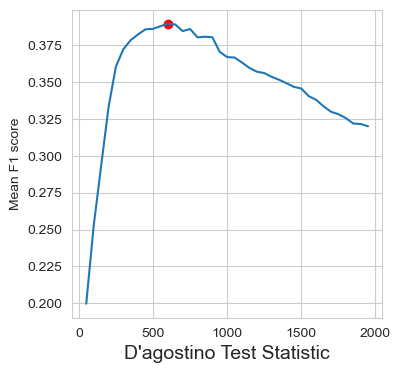

In [38]:
ica_data_merged.reoptimize_thresholds()

In [39]:
ica_data_merged.recompute_thresholds(600)

In [43]:
robust_iterative_M_Gene_Presence_Matrix = imdb_gene_presence(ica_data_merged)[0]

In [44]:
import pandas as pd

def map_accession_to_gene_name(df, biocyc_info):

    # Reset index if 'Accession-1' is the index, and rename the column
    if df.index.name == 'Accession' or df.index.name is None:
        df = df.reset_index()
        df.rename(columns={'index': 'Accession'}, inplace=True)
        
    # Merge with biocyc_info to map 'Accession-1' to 'Gene Name'
    merged_df = df.merge(biocyc_info[['Accession', 'Gene Name']], on='Accession', how='left')

    # Set 'Gene Name' as the new index and drop the 'Accession-1' column
    merged_df.set_index('Gene Name', inplace=True)
    merged_df.drop(columns=['Accession'], inplace=True)

    # Remove rows with NaN as index
    merged_df = merged_df[merged_df.index.notna()]
    
    return merged_df

In [45]:
robust_iterative_M_Gene_Presence_Matrix = map_accession_to_gene_name(robust_iterative_M_Gene_Presence_Matrix, biocyc_info)

In [46]:
P1K_Gene_Presence_Matrix = map_accession_to_gene_name(P1K_Gene_Presence_Matrix, biocyc_info)

In [47]:
robust_iterative_M_Gene_Presence_Matrix

,A_1,A_2,A_3,A_4,A_5,A_6,A_7,A_8,A_9,A_10,...,D_1,D_2,D_3,D_4,D_5,D_6,D_7,D_8,D_9,D_10
Gene Name,,,,,,,,,,,,,,,,,,,,,
thrA,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
thrB,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
thrC,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
yaaX,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
yaaA,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yneP,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
ynfT,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
yoaL,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [48]:
ica_data_merged.M

,A_1,A_2,A_3,A_4,A_5,A_6,A_7,A_8,A_9,A_10,...,D_1,D_2,D_3,D_4,D_5,D_6,D_7,D_8,D_9,D_10
b0002,0.024034,0.018525,0.016166,0.040623,0.001050,-0.033382,0.015661,0.015288,-0.016652,-0.011812,...,-0.003975,0.007600,-0.003317,-0.000877,0.030980,-0.016102,0.078858,0.005006,0.007679,-0.003730
b0003,0.012898,-0.008416,-0.000040,-0.008665,0.013254,0.003696,-0.001774,0.013162,0.005939,-0.001877,...,0.014653,0.015475,0.021471,-0.005951,0.000164,-0.004905,0.174350,-0.016998,0.003181,-0.005412
b0004,0.010681,-0.005803,-0.012882,-0.008442,0.015614,0.003813,-0.008055,0.008198,0.011393,0.001797,...,0.010937,0.013535,0.005340,-0.005307,0.003210,0.004922,0.162774,-0.009174,0.002461,-0.009814
b0005,-0.001047,-0.012467,0.000966,0.003840,0.048579,-0.000104,-0.003148,0.026390,0.012262,0.010439,...,0.021421,-0.018389,0.039259,0.002396,0.003260,0.011787,0.227051,0.018088,0.018654,0.001042
b0006,-0.009255,0.011460,-0.027613,-0.003211,-0.001700,-0.004914,-0.001978,-0.002577,-0.000378,0.005806,...,-0.012711,-0.007417,-0.004758,-0.003492,0.002106,0.000079,-0.009807,-0.003200,-0.014389,-0.003869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4747,-0.010751,-0.007346,-0.007724,0.012407,-0.018535,0.005556,0.009271,0.014031,0.006334,-0.017332,...,-0.004675,0.017604,0.007218,0.002328,-0.006849,0.012919,-0.007639,-0.025252,0.013928,-0.021327
b4748,0.011982,0.012511,0.005957,0.005079,0.022270,-0.000812,-0.001583,0.007502,-0.001684,0.023885,...,-0.004994,-0.000145,0.011457,0.010980,0.016623,-0.073538,-0.004820,-0.018917,0.038045,-0.018607
b4751,-0.003050,-0.006480,-0.022105,-0.014313,-0.003342,0.001192,0.001745,-0.026682,-0.003113,0.023562,...,0.001165,0.022143,-0.023472,-0.001955,-0.002674,0.001278,0.000349,-0.011492,0.076683,0.001030
b4755,-0.014514,0.000716,0.007938,0.004675,-0.006098,0.003059,-0.011157,0.003518,0.002673,-0.034160,...,0.003988,-0.001107,0.000338,0.003070,0.014136,0.046859,-0.002686,0.001411,0.026640,0.015945


In [49]:
ica_data_merged.M['A_1'].var()

0.0002332723749347378

In [50]:
ica_data_merged.M['B_2'].var()

0.00022009066788528195

In [51]:
ica_data_merged.M['C_3'].var()

0.00023018306890869238

In [52]:
ica_data_merged.M['D_5'].var()

0.00021969269529301618

In [53]:
Match_robust_iterative_M_to_P1K.loc[Match_robust_iterative_M_to_P1K['status'] == 'New']

,Merged M,PRECISE-1K,correlation,status
138,B_1,gcvB,0.071373,New
147,B_10,Ile/Val,0.081533,New
165,B_28,Glyoxylate,0.137203,New
166,B_29,Acetate,0.499765,New
168,B_31,NtrC-1,0.115750,New
173,B_36,UC-8,0.085455,New
180,C_4,UC-8,0.284663,New
182,C_6,thrA KO,0.094245,New
183,C_7,UC-7,0.255024,New
185,C_9,Glutarate,0.158502,New


### New iM from iteration 2

#### B_10 iModulon

In [54]:
def plot_gene_weights(ica_data, imodulon, by="start", xaxis=None, xname="", save_as=None, **kwargs):
    """
    Plot gene weights on a scatter plot.

    Parameters
    ----------
    ica_data: ~pymodulon.core.IcaData
        :class:`~pymodulon.core.IcaData` object
    imodulon : int or str
        `iModulon` name
    by: 'log-tpm-norm', 'length', or 'start'
        Property to plot on x-axis. Superceded by `xaxis`
    xaxis: list, dict or ~pandas.Series, optional
        Values on custom x-axis
    xname: str, optional
        Name of x-axis if using custom x-axis
    save_as: str, optional
        File name to save the plot as SVG
    **kwargs:
        Additional keyword arguments passed to :func:`pymodulon.plotting.scatterplot`
    Returns
    -------
    ax: ~matplotlib.axes.Axes
        :class:`~matplotlib.axes.Axes` containing the scatterplot
    """
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Arial.ttf'
    font_prop = fm.FontProperties(fname=font_path)

    # Check that iModulon exists
    if imodulon in ica_data.M.columns:
        y = ica_data.M[imodulon]
        ylabel = f"{imodulon} Gene Weight"
    else:
        raise ValueError(f"iModulon does not exist: {imodulon}")

    # Get genes in the iModulon
    bin_M = ica_data.M_binarized
    component_genes = set(bin_M[imodulon].loc[bin_M[imodulon] == 1].index)
    other_genes = set(bin_M[imodulon].loc[bin_M[imodulon] == 0].index)

    # If experimental `xaxis` parameter is used, use custom values for x-axis
    if xaxis is not None:
        x = _set_xaxis(xaxis=xaxis, y=y)
        xlabel = xname

    else:
        # Ensure 'by' has a valid input and assign x, xlabel accordingly
        if by == "log-tpm":
            x = ica_data.log_tpm.mean(axis=1)
            xlabel = "Mean Expression"
        elif by == "log-tpm-norm":
            x = ica_data.X.mean(axis=1)
            xlabel = "Mean Centered Expression"
        elif by == "length":
            x = np.log10(ica_data.gene_table.length)
            xlabel = "Gene Length (log10-scale)"
        elif by == "start":
            x = ica_data.gene_table.start
            xlabel = "Gene Start (1e6)"
        else:
            raise ValueError(
                '"by" must be "log-tpm", "log-tpm-norm", "length", or "start"'
            )

    # Override specific kwargs (their implementation is different in this function)
    show_labels_pgw = kwargs.pop("show_labels", "auto")
    adjust_labels_pgw = kwargs.pop("adjust_labels", True)
    legend_kwargs_pgw = kwargs.pop("legend_kwargs", {})
    label_font_kwargs_pgw = kwargs.pop("label_font_kwargs", {})

    kwargs["show_labels"] = kwargs["adjust_labels"] = False

    # Remove xlabel and ylabel kwargs if provided
    kwargs.pop("xlabel", None)
    kwargs.pop("ylabel", None)

    # Default legend should be on the side of the plot
    if (
        "bbox_to_anchor" not in legend_kwargs_pgw.keys()
        and "loc" not in legend_kwargs_pgw.keys()
    ):
        legend_kwargs_pgw.update({"bbox_to_anchor": (1, 1), "loc": 2})
        kwargs["legend_kwargs"] = legend_kwargs_pgw

    # Update colors for COG groups
    if "COG" in ica_data.gene_table.columns and "groups" not in kwargs:
        mod_cogs = ica_data.gene_table.loc[component_genes].COG
        hidden_cogs = pd.Series("hidden", index=other_genes)
        all_cogs = pd.concat([mod_cogs, hidden_cogs])
        kwargs.update({"groups": all_cogs, "colors": ica_data.cog_colors})

    # Scatter Plot
    ax = scatterplot(x, y, xlabel=xlabel, ylabel=ylabel, **kwargs)

    # Remove grid
    ax.grid(False)

    # Add black box around the plot
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)

    # Add thresholds to scatter-plot (dashed lines)
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    thresh = ica_data.thresholds[imodulon]
    if thresh != 0:
        ax.hlines(
            [thresh, -thresh],
            xmin=xmin,
            xmax=xmax,
            colors="k",
            linestyles="dashed",
            linewidth=1,
        )

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    texts = []
    expand_kwargs = {"expand_objects": (1.2, 1.4), "expand_points": (1.3, 1.3)}

    # Add labels: Put gene name if components contain under 20 genes
    if show_labels_pgw is True or (
        show_labels_pgw is not False and len(component_genes) <= 20
    ):
        for gene in component_genes:
            # Add labels
            text_kwargs = label_font_kwargs_pgw.copy()

            if "fontstyle" not in text_kwargs:
                text_kwargs.update({"fontstyle": "normal"})

            # Italicize gene if there is a defined name (not locus tag)
            try:
                gene_name = ica_data.gene_table.loc[gene, "gene_name"]

                if gene_name != gene:
                    text_kwargs.update({"fontstyle": "italic"})

            except KeyError:
                gene_name = gene

            # Set default fontsize
            if "fontsize" not in text_kwargs:
                text_kwargs.update({"fontsize": 12})

            texts.append(
                ax.text(
                    x[gene],
                    ica_data.M.loc[gene, imodulon],
                    gene_name,
                    fontproperties=font_prop,
                    **text_kwargs,
                )
            )

        expand_kwargs["expand_text"] = (1.4, 1.4)

    # Add labels: Repel texts from other text and points
    rect = ax.add_patch(
        Rectangle(
            xy=(xmin, -abs(thresh)),
            width=xmax - xmin,
            height=2 * abs(thresh),
            fill=False,
            linewidth=0,
        )
    )

    if adjust_labels_pgw:
        adjust_text(
            texts=texts,
            add_objects=[rect],
            ax=ax,
            arrowprops=dict(arrowstyle="-", color="k", lw=0.5),
            only_move={"objects": "y"},
            **expand_kwargs,
        )

    # Save plot to SVG format if save_as is provided
    if save_as:
        plt.savefig(save_as, format='svg')

    return ax

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from adjustText import adjust_text
from matplotlib.ticker import FuncFormatter  # Import FuncFormatter

def scatterplot(
    x,
    y,
    groups=None,
    colors=None,
    show_labels="auto",
    adjust_labels=True,
    line45=False,
    line45_margin=0,
    fit_line=False,
    fit_metric="pearson",
    xlabel="",
    ylabel="",
    ax=None,
    legend=True,
    ax_font_kwargs=None,
    scatter_kwargs=None,
    label_font_kwargs=None,
    legend_kwargs=None,
):

    # Path to your custom font
    font_path = '/usr/share/fonts/truetype/msttcorefonts/Arial.ttf'
    font_prop = fm.FontProperties(fname=font_path)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 3.5))

    if show_labels == "auto":
        show_labels = len(x) <= 20

    if not (
        isinstance(x, pd.Series)
        and isinstance(y, pd.Series)
        and (
            x.index.astype(str).sort_values() == y.index.astype(str).sort_values()
        ).all()
    ):
        raise TypeError("X and Y must be pandas series with the same index")

    # Set up data object
    data = pd.DataFrame({"x": x, "y": y})

    # Add group information
    data["group"] = ""
    if groups is not None:
        for k, val in groups.items():
            data.loc[k, "group"] = val

    # Handle custom kwargs
    if ax_font_kwargs is None:
        ax_font_kwargs = {}

    if label_font_kwargs is None:
        label_font_kwargs = {}

    if legend_kwargs is None:
        legend_kwargs = {}

    if scatter_kwargs is None:
        scatter_kwargs = {}

    # Get x and y limits
    margin = 0.1
    xrange = x.max() - x.min()
    yrange = y.max() - y.min()
    xmin = x.min() - xrange * margin
    xmax = x.max() + xrange * margin
    ymin = y.min() - yrange * margin
    ymax = y.max() + yrange * margin
    allmin = max(xmin, ymin)
    allmax = min(xmax, ymax)

    # Add 45 degree line
    if line45:
        # Plot diagonal lines
        ax.plot(
            [allmin, allmax],
            [allmin, allmax],
            color="k",
            linestyle="dashed",
            linewidth=0.5,
            zorder=0,
        )

        if line45_margin > 0:
            diff = pd.DataFrame(abs(data.x - data.y), index=data.index)
            hidden = diff.loc[diff[0] < line45_margin]
            data.loc[hidden.index, "group"] = "hidden"
            ax.plot(
                [max(xmin, ymin + line45_margin), min(xmax, ymax + line45_margin)],
                [max(ymin, xmin - line45_margin), min(ymax, xmax - line45_margin)],
                color="gray",
                linestyle="dashed",
                linewidth=0.5,
                zorder=0,
            )
            ax.plot(
                [max(xmin, ymin - line45_margin), min(xmax, ymax - line45_margin)],
                [max(ymin, xmin + line45_margin), min(ymax, xmax + line45_margin)],
                color="gray",
                linestyle="dashed",
                linewidth=0.5,
                zorder=0,
            )

    # Add colors to the data
    # If colors is already a dict, just update the hidden color
    try:
        if "hidden" not in colors.keys():
            colors.update({"hidden": "gray"})
        if "" not in colors.keys():
            colors.update({"": "tab:blue"})
    except AttributeError:

        groups = [item for item in data["group"].unique() if item != "hidden"]
        if colors is None:
            colorlist = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        elif isinstance(colors, str):
            colorlist = [colors] * len(groups)
        else:
            colorlist = list(colors)

        # Deal with short colorlists
        if len(colorlist) < len(groups):
            colorlist = colorlist * (len(groups) // len(colorlist) + 1)

        colors = dict(zip(groups, colorlist))
        colors.update({"hidden": "gray"})

    # for name, group in data.groupby("group"):
    #     kwargs = scatter_kwargs.copy()
    #     kwargs["color"] = colors[name]
    #     # Override defaults for hidden points
    #     if name == "hidden":
    #         kwargs.update({"alpha": 0.7, "linewidth": 0, "label": None})
    #     elif name == "":
    #         kwargs.update({"label": None})
    #     else:
    #         kwargs.update({"label": name})

    #     ax.scatter(group.x, group.y, **kwargs, zorder=1)
    for name, group in data.groupby("group"):
        kwargs = scatter_kwargs.copy()
        kwargs["color"] = colors[name]
    
        if name == "hidden":
            kwargs.update({"alpha": 0.7, "linewidth": 0, "label": None})
            pc = ax.scatter(group.x, group.y, **kwargs, zorder=1)
            pc.set_rasterized(True)          # <--- key line
            # optional: make sure it's actually rasterized on save
            # pc.set_zorder(0)  # if you want it behind other points
        else:
            if name == "":
                kwargs.update({"label": None})
            else:
                kwargs.update({"label": name})
            ax.scatter(group.x, group.y, **kwargs, zorder=1)

    # Add regression
    if fit_line:
        _fit_line(x, y, ax, fit_metric)

    # Add lines at 0
    if xmin < 0 < xmax:
        ax.hlines(0, xmin, xmax, linewidth=0.5, color="gray", zorder=2)
    if ymin < 0 < ymax:
        ax.vlines(0, ymin, ymax, linewidth=0.5, color="gray", zorder=2)

    # Add labels
    if show_labels:
        texts = []
        for idx in x.index:
            texts.append(ax.text(x[idx], y[idx], idx, fontproperties=font_prop, **label_font_kwargs))
        if adjust_labels:
            adjust_text(
                texts,
                ax=ax,
                arrowprops=dict(arrowstyle="-", color="k", lw=0.5),
                only_move={"objects": "y"},
                expand_objects=(1.2, 1.4),
                expand_points=(1.3, 1.3),
            )

    if np.allclose(xmin, xmax):
        ax.set_xlim(xmin - 1, xmax + 1)
    else:
        ax.set_xlim(xmin, xmax)

    if np.allclose(ymin, ymax):
        ax.set_ylim(ymin - 1, ymax + 1)
    else:
        ax.set_ylim(ymin, ymax)

    ax.set_xlabel(xlabel, fontproperties=font_prop, **ax_font_kwargs)
    ax.set_ylabel(ylabel, fontproperties=font_prop, **ax_font_kwargs)

    if legend or fit_line:
        legend = ax.legend(**legend_kwargs)
        for text in legend.get_texts():
            text.set_font_properties(font_prop)
            
    # Apply font to tick labels
    for tick in ax.get_xticklabels():
        tick.set_font_properties(font_prop)
    for tick in ax.get_yticklabels():
        tick.set_font_properties(font_prop)
        
    # Ensure y-ticks have two decimal places
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.2f}'))

    return ax


<AxesSubplot:xlabel='Gene Start (1e6)', ylabel='B_10 Gene Weight'>

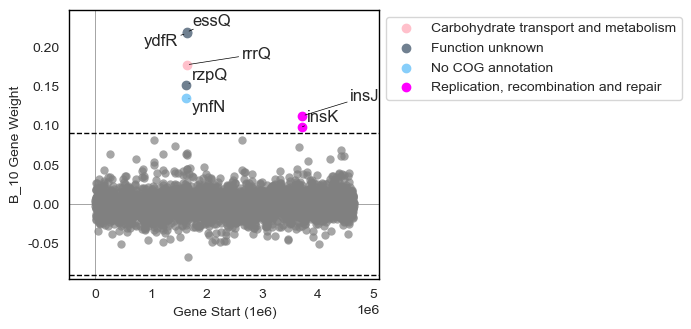

In [56]:
plot_gene_weights(ica_data_merged, 'B_10', save_as = 'essQ_iM_iterative_ICA.svg')

<AxesSubplot:xlabel='Gene Start (1e6)', ylabel='B_28 Gene Weight'>

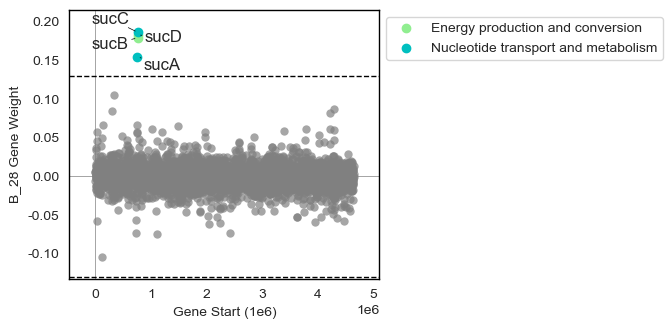

In [57]:
plot_gene_weights(ica_data_merged, 'B_28', save_as = 'suc_iM_iterative_ICA.svg')

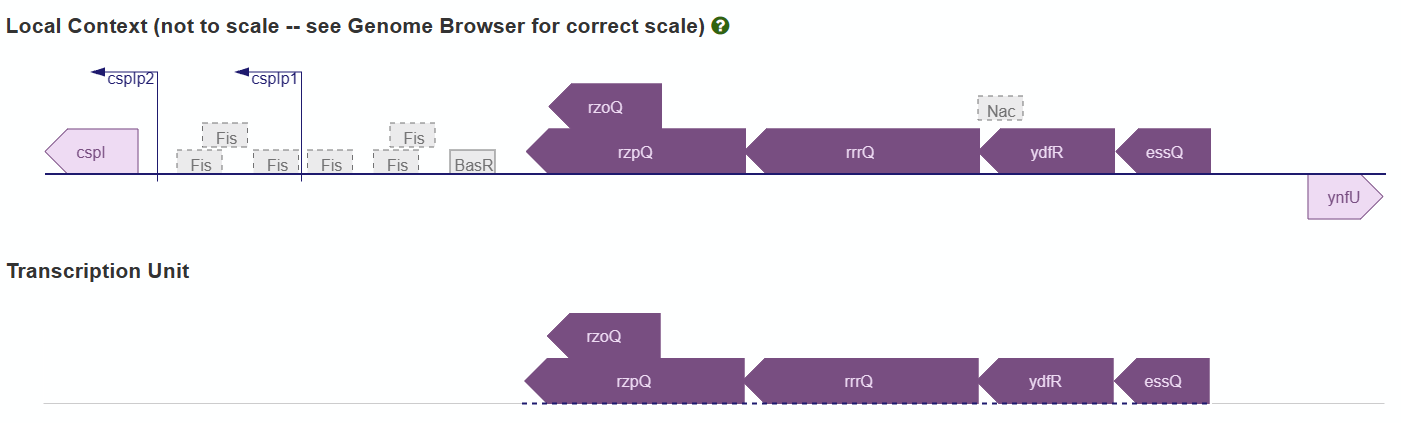

<AxesSubplot:ylabel='B_10 iModulon\nActivity'>

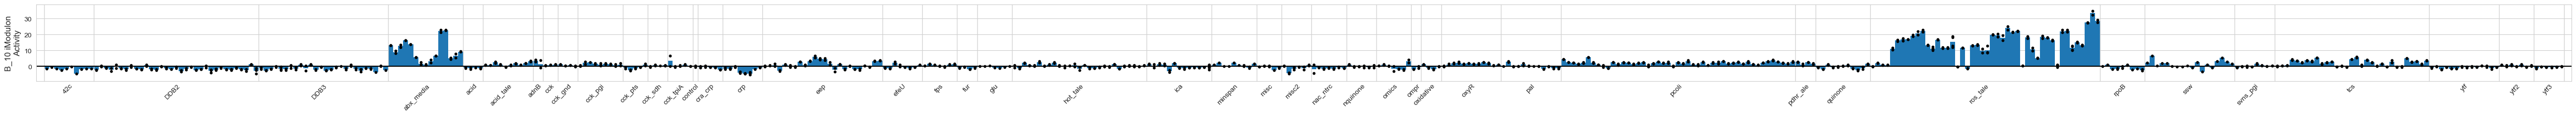

In [58]:
plot_activities(ica_data_merged, 'B_10')

#### B_28 iModulon - suc iModulon

<AxesSubplot:xlabel='Gene Start (1e6)', ylabel='B_28 Gene Weight'>

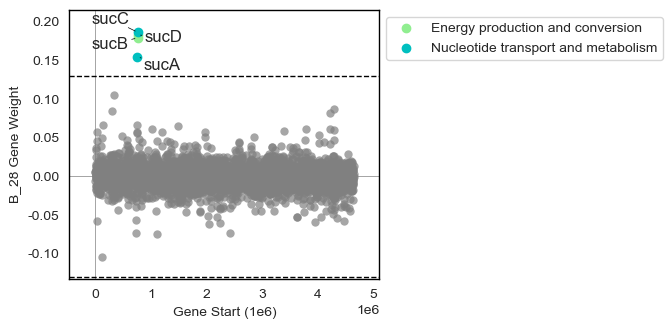

In [59]:
plot_gene_weights(ica_data_merged, 'B_28')

<AxesSubplot:ylabel='B_28 iModulon\nActivity'>

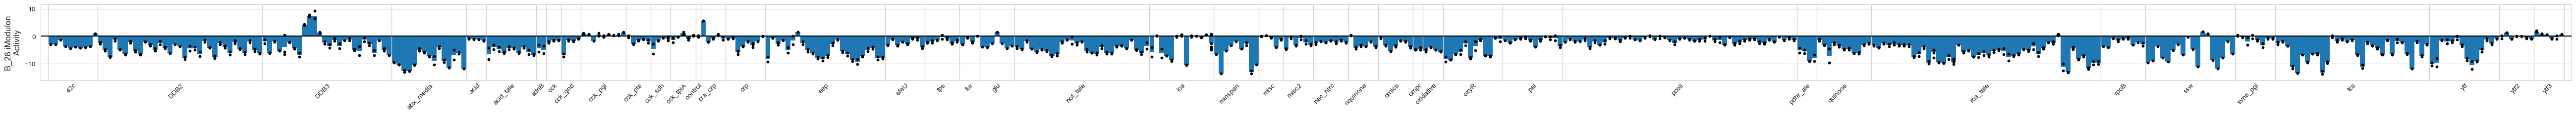

In [60]:
plot_activities(ica_data_merged, 'B_28')

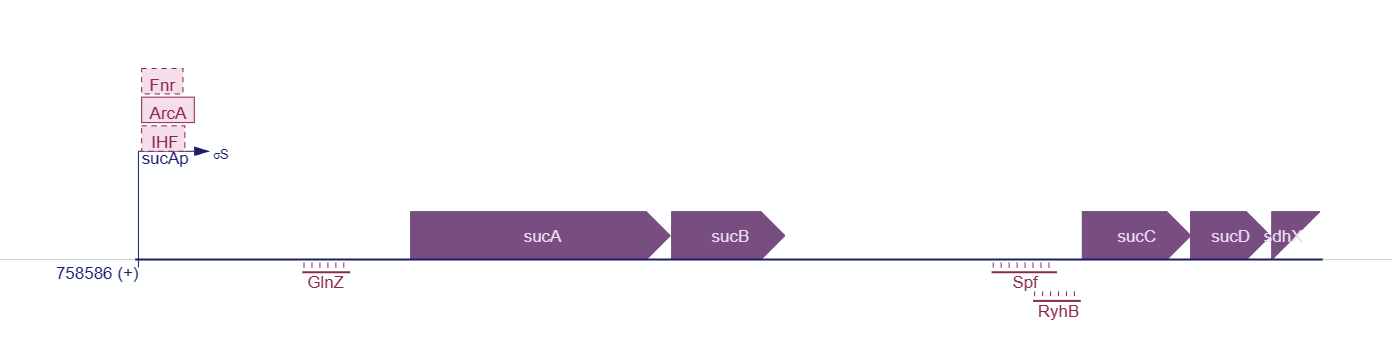

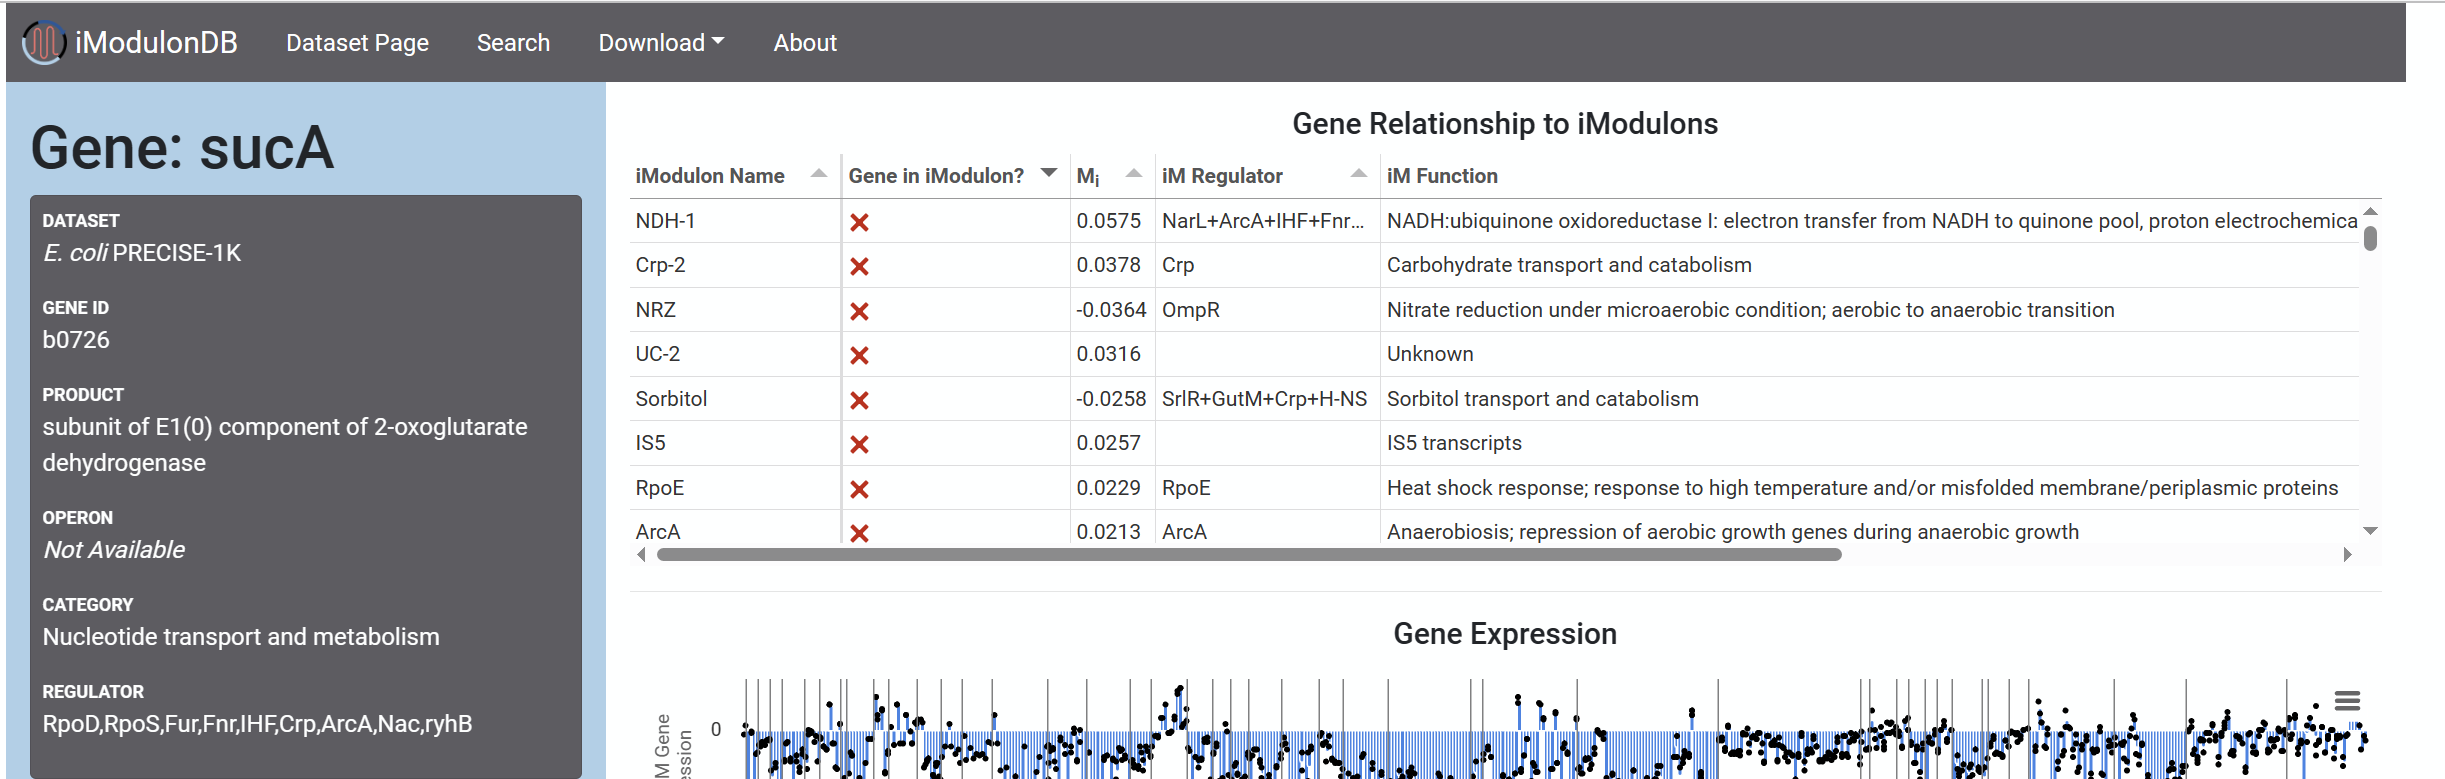

#### B_31 iModulon - sgc iModulon

<AxesSubplot:xlabel='Gene Start (1e6)', ylabel='B_31 Gene Weight'>

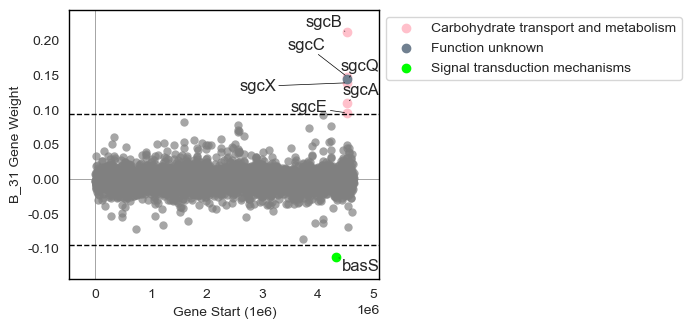

In [62]:
plot_gene_weights(ica_data_merged, 'B_31', save_as = 'sgc_iM_iterative_ICA.svg')

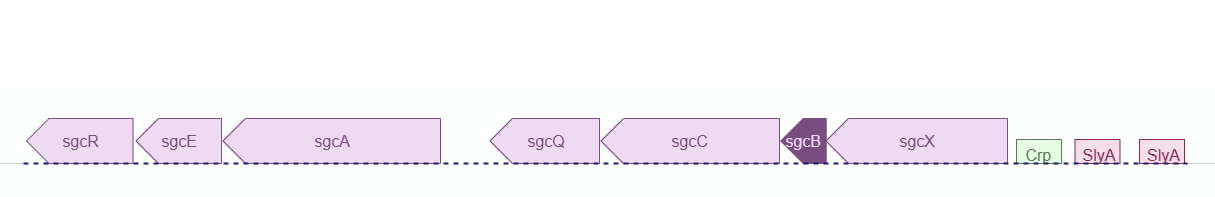

<AxesSubplot:ylabel='B_31 iModulon\nActivity'>

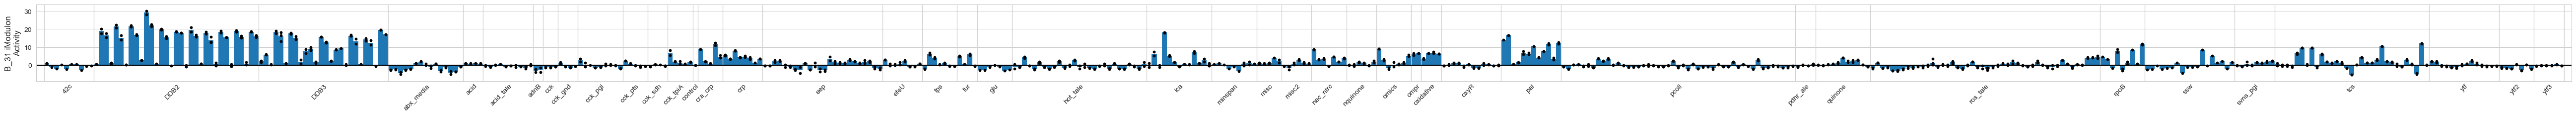

In [63]:
plot_activities(ica_data_merged, 'B_31')

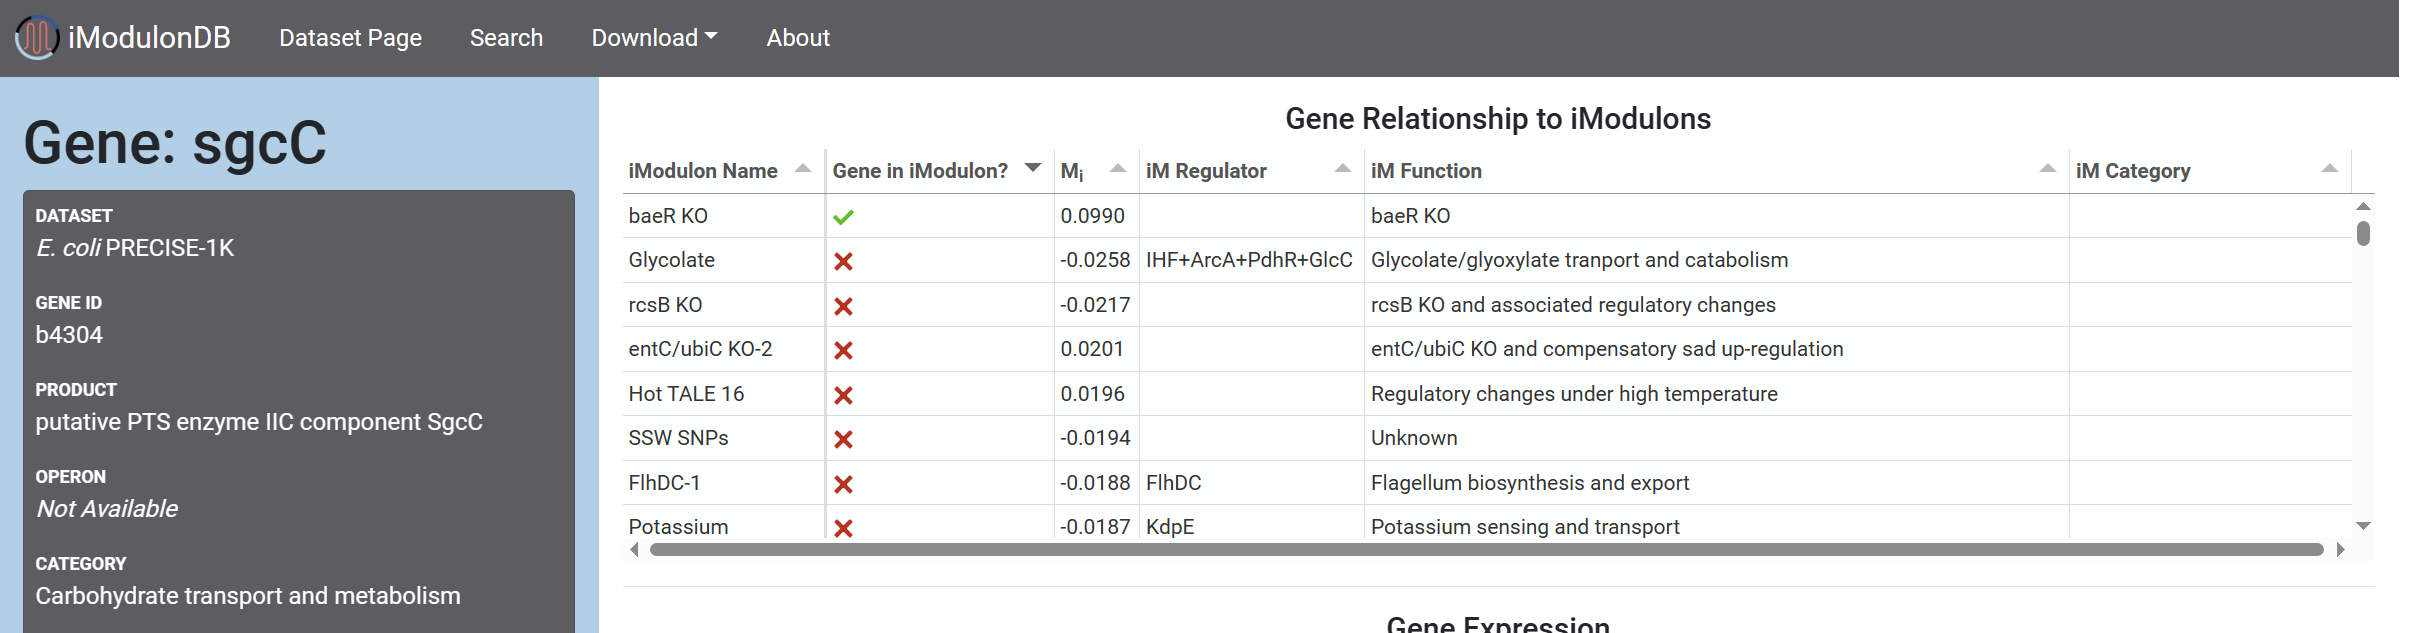

### New iM from iteration 3

#### C_6 iModulon

<AxesSubplot:xlabel='Gene Start (1e6)', ylabel='C_6 Gene Weight'>

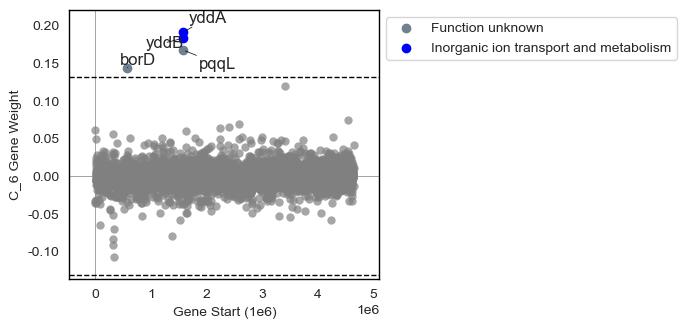

In [64]:
plot_gene_weights(ica_data_merged, 'C_6')

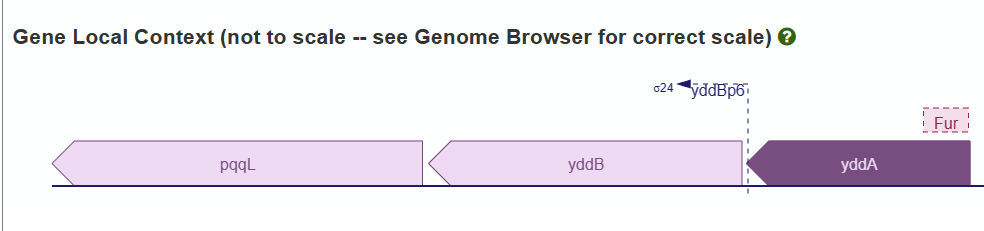